In [6]:
#Cài đặt thư viện
!pip install -q transformers==4.41.2
!pip install -q bitsandbytes==0.43.1
!pip install -q accelerate==0.31.0
!pip install -q langchain==0.2.5
!pip install -q langchainhub==0.1.20
!pip install -q langchain-chroma==0.1.1
!pip install -q langchain-community==0.2.5
!pip install -q langchain_huggingface==0.0.3
!pip install -q python-dotenv==1.0.1
!pip install -q pypdf==4.2.0
!pip install -q numpy==1.25.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 83.8 MB/s eta 0:00:00


In [7]:
#Import thư viện
import torch

from transformers import BitsAndBytesConfig
from transformers import AutoTokenizer,AutoModelForCausalLM,pipeline
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_huggingface.llms import HuggingFacePipeline
from langchain.memory import ConversationBufferMemory
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_community.document_loaders import PyPDFLoader,TextLoader
from langchain.chains import ConversationalRetrievalChain
from langchain_chroma import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain import hub

In [8]:
#Tải file pdf
!gdown 1lWuq0COKnU9mCfMvTEq54DBLgAh3yYDx

Downloading...
From: https://drive.google.com/uc?id=1lWuq0COKnU9mCfMvTEq54DBLgAh3yYDx
To: /content/YOLOv10_Tutorials.pdf
100% 16.6M/16.6M [00:00<00:00, 24.7MB/s]


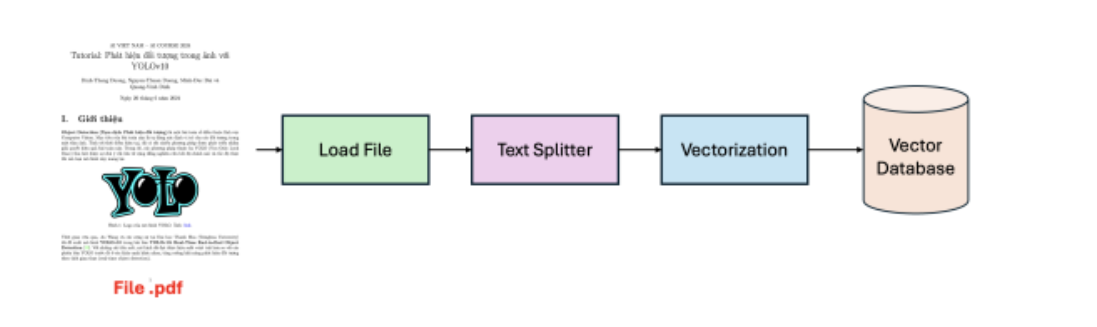

In [9]:
#Load File
Loader = PyPDFLoader
FILE_PATH = "./YOLOv10_Tutorials.pdf"
loader = Loader(FILE_PATH)
documents = loader.load()

In [10]:
#Tách tài liệu
text_splitter = RecursiveCharacterTextSplitter(chunk_size =1000,chunk_overlap =100)

In [11]:
docs = text_splitter.split_documents(documents)
print("Number of sub - documents :",len(docs))
print(docs[0])

Number of sub - documents : 33
page_content='AI VIET NAM – AI COURSE 2024\nTutorial: Phát hiện đối tượng trong ảnh với\nYOLOv10\nDinh-Thang Duong, Nguyen-Thuan Duong, Minh-Duc Bui và\nQuang-Vinh Dinh\nNgày 20 tháng 6 năm 2024\nI. Giới thiệu\nObject Detection (Tạm dịch: Phát hiện đối tượng) là một bài toán cổ điển thuộc lĩnh vực\nComputer Vision. Mục tiêu của bài toán này là tự động xác định vị trí của các đối tượng trong\nmột tấm ảnh. Tính tới thời điểm hiện tại, đã có rất nhiều phương pháp được phát triển nhằm\ngiải quyết hiệu quả bài toán này. Trong đó, các phương pháp thuộc họ YOLO (You Only Look\nOnce) thu hút được sự chú ý rất lớn từ cộng đồng nghiên cứu bởi độ chính xác và tốc độ thực\nthi mà loại mô hình này mang lại.\nHình 1: Logo của mô hình YOLO. Ảnh: link.\nThời gian vừa qua, Ao Wang và các cộng sự tại Đại học Thanh Hoa (Tsinghua University)\nđã đề xuất mô hình YOLOv10 trong bài báo YOLOv10: Real-Time End-to-End Object\nDetection [10]. Với những cải tiến mới, mô hình đã đạt 

In [12]:
#Chuyển văn bản thành vector
embedding = HuggingFaceEmbeddings()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [13]:
# Khởi tạo vector database
vector_db = Chroma.from_documents(documents=docs,embedding=embedding)
retriever = vector_db.as_retriever()

In [14]:
# Thực Hiện Truy Vấn
result = retriever.invoke(" What is YOLO ?")
print("Number of relevant documents :",len(result))

Number of relevant documents : 4


In [15]:
#Khởi tạo mô hình lớn, Vicuna
# Khai báo 1 số cài đặt cần thiết
nf4_config = BitsAndBytesConfig (
  load_in_4bit = True,
  bnb_4bit_quant_type ="nf4",
  bnb_4bit_use_double_quant =True,
  bnb_4bit_compute_dtype = torch.bfloat16
)

In [16]:
#Khởi tạo mô hình và tokenizer:
MODEL_NAME = "lmsys/vicuna-7b-v1.5"

model = AutoModelForCausalLM.from_pretrained (
MODEL_NAME,
quantization_config = nf4_config,
low_cpu_mem_usage = True
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/162 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:520: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuratio

tokenizer_config.json:   0%|          | 0.00/749 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

In [17]:
#Tích hợp tokenizer và model thành một pipeline để tiện sử dụng
model_pipeline = pipeline(
  "text-generation",
  model = model,
  tokenizer = tokenizer,max_new_tokens = 512,
  pad_token_id = tokenizer.eos_token_id,
  device_map = "auto"
)

llm = HuggingFacePipeline (
  pipeline = model_pipeline,
)

In [18]:
#Chạy chương trình
prompt = hub.pull("rlm/rag-prompt")

def format_docs(docs):
  return "\n\n".join(doc.page_content for doc in docs )

rag_chain = (
 {"context": retriever|format_docs,"question":RunnablePassthrough() }
  | prompt
  | llm
  | StrOutputParser()
)

USER_QUESTION = "YOLOv10 là gì?"
output = rag_chain.invoke(USER_QUESTION)
answer = output.split("Answer:")[1].strip()
print(answer)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:520: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


YOLOv10 là một phiên bản của YOLO (You Only Look Once) - một hệ thống dự đoán hình ảnh được huấn luyện sẵn trên bộ dữ liệu COCO. Phiên bản này được tạo bằng cách tải về trọng số (file.pt) từ GitHub và khởi tạo mô hình bằng cách sử dụng thư viện ultralytics.


Xây dựng UI/UX

In [19]:
# Cài đặt thư viện
!pip install chainlit
import chainlit as cl
import torch

from chainlit.types import AskFileResponse

from transformers import BitsAndBytesConfig
from transformers import AutoTokenizer,AutoModelForCausalLM,pipeline
from langchain_huggingface.llms import HuggingFacePipeline

from langchain.memory import ConversationBufferMemory
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain.chains import ConversationalRetrievalChain

from langchain_huggingface import HuggingFaceEmbeddings
from langchain_chroma import Chroma
from langchain_community.document_loaders import PyPDFLoader,TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain import hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 73.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 kB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 9.9 MB/s eta 0:00:00
  Created wheel for literalai: filename=literalai-0.0.607-py3-none-any.whl size=64143 sha256=090b90c110c81b8fc20aa96fbc907bd01630b0de39193239b9f0eef1e8acb2f5
  Stored in directory: /root/.cache/pip

In [20]:
# chuyển text thành vector
text_splitter = RecursiveCharacterTextSplitter(chunk_size =1000,chunk_overlap =100)

embedding = HuggingFaceEmbeddings ()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [21]:
# Xây dựng hàm xử lý file input đầu vào
def process_file(file : AskFileResponse) :
 if file.type == "text/plain" :
    Loader = TextLoader
 elif file.type == "application/pdf" :
    Loader = PyPDFLoader

 loader = Loader(file.path)
 documents = loader.load()
 docs = text_splitter.split_documents(documents)
 for i, doc in enumerate(docs):
    doc.metadata["source"] = f"source_ {i}"
 return docs

In [22]:
#Xây dựng hàm khởi tạo Chroma database
def get_vector_db(file : AskFileResponse) :
 docs = process_file(file)
 cl.user_session.set("docs",docs)
 vector_db = Chroma.from_documents(documents =docs,embedding = embedding)
 return vector_db

In [23]:
#Khởi tạo mô hình ngôn ngữ lớn
def get_huggingface_llm(model_name:str="lmsys/vicuna-7b-v1.5", max_new_token:int=512):
    nf4_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_use_double_quant=True,
        bnb_4bit_compute_dtype=torch.bfloat16
    )

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        quantization_config=nf4_config,
        low_cpu_mem_usage=True
    )

    tokenizer = AutoTokenizer.from_pretrained(model_name)

    model_pipeline = pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        max_new_tokens=max_new_token,
        pad_token_id=tokenizer.eos_token_id,
        device_map="auto"
    )

    llm = HuggingFacePipeline(pipeline=model_pipeline)
    return llm

LLM = get_huggingface_llm()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:520: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuratio

In [24]:
#Khởi tạo welcome message:
welcome_message = """ Welcome to the PDF QA! To get started :
1. Upload a PDF or text file
2. Ask a question about the file
"""

In [25]:
#Khởi tạo hàm on_chat_start
@cl.on_chat_start
async def on_chat_start():
    files = None
    while files is None:
        files = await cl.AskFileMessage(
            content=welcome_message,
            accept=["text/plain", "application/pdf"],
            max_size_mb=20,
            timeout=180,
        ).send()

    file = files[0]

    msg = cl.Message(content=f"Processing \"{file.name}\"...", disable_feedback=True)
    await msg.send()

    vector_db = await cl.make_async(get_vector_db)(file)

    message_history = ChatMessageHistory()
    memory = ConversationBufferMemory(
        memory_key="chat_history",
        output_key="answer",
        chat_memory=message_history,
        return_messages=True,
    )
    retriever = vector_db.as_retriever(search_type="mmr", search_kwargs={"k": 3})

    chain = ConversationalRetrievalChain.from_llm(
        llm=LLM,
        chain_type="stuff",
        retriever=retriever,
        memory=memory,
        return_source_documents=True
    )

    msg.content = f"{file.name} processed. You can now ask questions!"
    await msg.update()

    cl.user_session.set("chain", chain)


In [26]:
#Khởi tạo hàm on_message
@cl.on_message
async def on_message(message: cl.Message):
    chain = cl.user_session.get("chain")
    cb = cl.AsyncLangchainCallbackHandler()
    res = await chain.ainvoke(message.content, callbacks=[cb])
    answer = res["answer"]
    source_documents = res["source_documents"]
    text_elements = []

    if source_documents:
        for source_idx, source_doc in enumerate(source_documents):
            source_name = f"source_{source_idx}"
            text_elements.append(
                cl.Text(content=source_doc.page_content, name=source_name)
            )
        source_names = [text_el.name for text_el in text_elements]

        if source_names:
            answer += f"\nSources: {', '.join(source_names)}"
        else:
            answer += "\nNo sources found"

    await cl.Message(content=answer, elements=text_elements).send()

In [27]:
#Chạy chainlit app
!chainlit run app.py --host 0.0.0.0 --port 8000 &> /content/logs.txt &

In [28]:
# import thư viện
import urllib

In [29]:
# nhả password ip
ip = urllib.request.urlopen("https://ipv4.icanhazip.com").read().decode("utf8").strip("\n")
print("Password/Enpoint IP for localtunnel is:", ip)

Password/Enpoint IP for localtunnel is: 34.143.152.66


In [30]:
# tải localtunnel
!npm install -g localtunnel

/tools/node/bin/lt -> /tools/node/lib/node_modules/localtunnel/bin/lt.js
+ localtunnel@2.0.2
added 22 packages from 22 contributors in 2.063s


In [ ]:
#deploy
!lt --port 8000 --subdomain aivn-simple-rag

your url is: https://aivn-simple-rag.loca.lt
